In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import pydicom 
from os import listdir
from pathlib import Path
import cv2
import random 
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

plt.style.use('ggplot')



In [4]:
keras.__version__


'2.4.0'

In [5]:
def channelWisePreProcess_v4(img3d, rangeMin, rangeMax):
    temp1 = img3d
    # temp = T1c[T1c>0].reshape(240,240,155)
    temp_mean = np.mean(img3d[img3d>0])
    temp_std = np.std(img3d[img3d>0])
    temp1 = (temp1-temp_mean)/temp_std
    temp1[temp1 > rangeMax] = rangeMax
    temp1[temp1 < rangeMin] = rangeMin
    temp_min = np.min(temp1[img3d>0])
    temp_max = np.max(temp1[img3d>0])

    temp1 = (temp1-temp_min)/(temp_max-temp_min)*0.95+0.05
    temp1[img3d <=0] = 0
    return temp1

def rotate_images(image, img_size):
    scale =1.0
    h = img_size
    w = img_size
    center = (h/2,w/2)
    angle = random.randint(-25,25)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (h,w))
    return rotated

def translation (image):
    x= random.randint(-30,30)
    y = random.randint(-30,30)
    rows,cols,z = image.shape
    M = np.float32([[1,0,x],[0,1,y]])
    translate = cv2.warpAffine(image,M,(cols,rows))
    
    return translate

def blur (image):
    x = random.randrange(1,5,2)
    blur = cv2.GaussianBlur(image,(x,x),cv2.BORDER_DEFAULT)
    return blur

def apply_aug (image, img_size):
    number = random.randint(1,2)
    
    if number == 1:
        image= rotate_images(image, img_size)
                
    if number ==2:
        image= translation(image)
                
    if number ==3:
        image= blur(image)
    
    return image

def oversample_images(X, y, img_size):
    
    counter = 0
    new_img = []
    new_label = []
    difference = len(y) - 2*y.sum()
    if difference > 0:
        lack_label = 1
    else: 
        lack_label = 0

    
    for i in range(len(y)):    
        
        if y[i] == lack_label and counter < difference:
            
            for j in range(round(difference/y.sum())+1):
                item = X[i]
                image = apply_aug(item, img_size)
                counter = counter+1
                new_img.append(image)
                new_label.append(lack_label)    
                
            if i == len(y) and counter < difference:
                n = random.randint(1,len(y))
                for j in range(difference - counter):
                    item = X[n]
                    image = apply_aug(item, img_size)
                    counter = counter+1
                    new_img.append(image)
                    new_label.append(lack_label)    

    
    new_img = np.array(new_img)
    new_label = np.array(new_label)
    
#     X_balanced = X.append(new_img)
#     y_balanced = y.append(new_label)

    
    return new_img, new_label


## Load data

In [6]:
## predictable label
labelname = 'is_icu'
col_uselist = ["to_patient_id", labelname]
col_namelist = ["ID", "label"]
label = pd.read_csv('/data/project/iqml/datasets/COVID-19-NY-SBU-CT/COVID-19-NY-SBU-labels.csv', usecols=col_uselist)
label = label.sort_values(by="to_patient_id", ignore_index=True)


file_list = listdir('/data/project/iqml/datasets/covid_xray_an1')

drop_ID = ['A002304', 'A025840', 'A046441', 'A113004', 'A142433', 'A300871', 'A308607', 'A437957', 'A482389', 'A563909',
           'A587516', 'A590713', 'A642300', 'A672510', 'A673634', 'A702750', 'A735762', 'A740973', 'A750765', 'A771386',
           'A776019', 'A825484', 'A934948']
drop_num = []
for i in range(len(label)):
    if not label['to_patient_id'][i] in file_list:
        drop_num.append(i)
    elif label['to_patient_id'][i] in drop_ID:
        drop_num.append(i)
    
print('drop:',drop_num, 'dropcases:', len(drop_num)) 
label = label.drop(drop_num)
label[labelname] = label[labelname].astype(int)
label

drop: [6, 21, 32, 34, 47, 62, 73, 154, 166, 212, 217, 242, 264, 354, 396, 407, 412, 425, 450, 538, 588, 623, 629, 642, 665, 760, 783, 787, 860, 899, 900, 938, 988, 995, 1007, 1048, 1054, 1143, 1225, 1290, 1327, 1381] dropcases: 42


,to_patient_id,is_icu
0,A000801,1
1,A000936,0
2,A001375,0
3,A001942,0
4,A002052,1
...,...,...
1378,A997729,0
1379,A998063,0
1380,A998860,0
1382,A999046,0


In [7]:
print("True: ",label.iloc[:,1].sum())
print("False: ",len(label.index) - label.iloc[:,1].sum())

True:  253
False:  1089


In [8]:
folder = '/data/project/iqml/datasets/covid_xray_an1/'
img_size = 256
tempdata = []
data = []

for i in label['to_patient_id']:
    
    dcmpath = Path(folder, i, i +'.dcm')
    tempdata = pydicom.dcmread(dcmpath)
    tempdata = tempdata.pixel_array
    tempdata = cv2.resize(tempdata, dsize=(img_size, img_size), interpolation=cv2.INTER_LINEAR)
    tempdata = np.dstack((tempdata,tempdata,tempdata))
    data.append(tempdata)
    print('load image:', i)
    
# plt.imshow(data.pixel_array, cmap=plt.cm.gray)
# plt.show()

load image: A000801
load image: A000936
load image: A001375
load image: A001942
load image: A002052
load image: A002279
load image: A002471
load image: A003797
load image: A005097
load image: A005163
load image: A008984
load image: A009815
load image: A010092
load image: A012155
load image: A013939
load image: A014950
load image: A016973
load image: A017004
load image: A017227
load image: A018604
load image: A019571
load image: A019709
load image: A020215
load image: A020333
load image: A020519
load image: A021084
load image: A022063
load image: A023023
load image: A023095
load image: A023545
load image: A024671
load image: A027284
load image: A027914
load image: A028914
load image: A030428
load image: A030820
load image: A031437
load image: A032808
load image: A033072
load image: A033798
load image: A034518
load image: A035738
load image: A035785
load image: A036454
load image: A038399
load image: A038686
load image: A038694
load image: A040293
load image: A041535
load image: A041791


load image: A324812
load image: A325534
load image: A326684
load image: A326951
load image: A327062
load image: A327819
load image: A329548
load image: A329601
load image: A330101
load image: A330665
load image: A331277
load image: A333626
load image: A333989
load image: A336129
load image: A337808
load image: A337940
load image: A338985
load image: A340910
load image: A340955
load image: A342018
load image: A342350
load image: A343597
load image: A345917
load image: A346398
load image: A347680
load image: A348739
load image: A349057
load image: A349238
load image: A349670
load image: A349708
load image: A349895
load image: A352067
load image: A352169
load image: A353550
load image: A353577
load image: A353725
load image: A354716
load image: A354769
load image: A355016
load image: A355608
load image: A357185
load image: A357192
load image: A357204
load image: A357644
load image: A358050
load image: A358446
load image: A358591
load image: A359779
load image: A360528
load image: A361904


load image: A632423
load image: A632768
load image: A635206
load image: A635855
load image: A635949
load image: A636688
load image: A637185
load image: A638206
load image: A639940
load image: A640895
load image: A641229
load image: A642580
load image: A643574
load image: A643986
load image: A644222
load image: A646350
load image: A647750
load image: A648209
load image: A648481
load image: A649144
load image: A650361
load image: A650418
load image: A651287
load image: A652157
load image: A652246
load image: A652563
load image: A653181
load image: A654278
load image: A654492
load image: A654746
load image: A656088
load image: A656786
load image: A657130
load image: A660468
load image: A661873
load image: A662513
load image: A662554
load image: A662862
load image: A665943
load image: A666238
load image: A667325
load image: A667780
load image: A667803
load image: A669966
load image: A670367
load image: A670597
load image: A670621
load image: A670911
load image: A671620
load image: A674773


load image: A920409
load image: A920434
load image: A920949
load image: A921077
load image: A921742
load image: A922673
load image: A923411
load image: A923527
load image: A925089
load image: A925517
load image: A925839
load image: A926330
load image: A926447
load image: A929180
load image: A929469
load image: A930175
load image: A933548
load image: A934023
load image: A934244
load image: A934713
load image: A936478
load image: A937798
load image: A937900
load image: A939326
load image: A940723
load image: A942131
load image: A942528
load image: A943106
load image: A943462
load image: A943557
load image: A943730
load image: A944071
load image: A944627
load image: A945737
load image: A945931
load image: A946381
load image: A946387
load image: A946930
load image: A947413
load image: A948013
load image: A948145
load image: A948163
load image: A948632
load image: A950017
load image: A951074
load image: A951258
load image: A951393
load image: A951435
load image: A951446
load image: A951599


In [9]:
np.shape(data)


(1342, 256, 256, 3)

## Load model (transfer learning)

In [10]:
# # load model and specify a new input shape for images
img_size = 256

res_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
for layer in res_model.layers[:143]:
    layer.trainable = False
for i, layer in enumerate(res_model.layers):
    print(i, layer.name, "-", layer.trainable)
res_model.summary()


# res_model = ResNet101(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
# # make con5 trainable
# # for layer in res_model.layers[:143]:
# #     layer.trainable = False
# for layer in res_model.layers[:313]:
#     layer.trainable = False
    
# # check trainable layers
# for i, layer in enumerate(res_model.layers):
#     print(i, layer.name, "-", layer.trainable)

# res_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
# # make con5 trainable
# for layer in res_model.layers[:15]:
#     layer.trainable = False
    
# # check trainable layers
# for i, layer in enumerate(res_model.layers):
#     print(i, layer.name, "-", layer.trainable)

# res_model.summary()

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [11]:
model = Sequential()
model.add(res_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(0.3))
# model.add(Dense(128))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                4194336   
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [137]:
# load VGG pretrained model

img_size = 256
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
# make con5 trainable
for layer in vgg_model.layers[:15]:
    layer.trainable = False
    
# check trainable layers
# for i, layer in enumerate(vgg_model.layers):
#     print(i, layer.name, "-", layer.trainable)
# vgg_model.summary()

model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_15 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 32768)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                1048608   
_________________________________________________________________
batch_normalization_15 (Batc (None, 32)                128       
_________________________________________________________________
activation_15 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

## Oversampling Testing data split + Imbalance(data augmentation)

In [12]:
x = np.array(data)
y = np.array(label[labelname])
# training testing split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True)
# oversampling
n_img,n_label = oversample_images(x_test, y_test, img_size)

x_test = np.append(x_test,n_img,axis=0)
print('x_test', x_test.shape)
y_test = np.append(y_test,n_label)
print('y_test', y_test.shape)

print("True: ", y_test.sum())
print("False: ",len(y_test) - y_test.sum())


x_test (444, 256, 256, 3)
y_test (444,)
True:  223
False:  221


Display Random Images


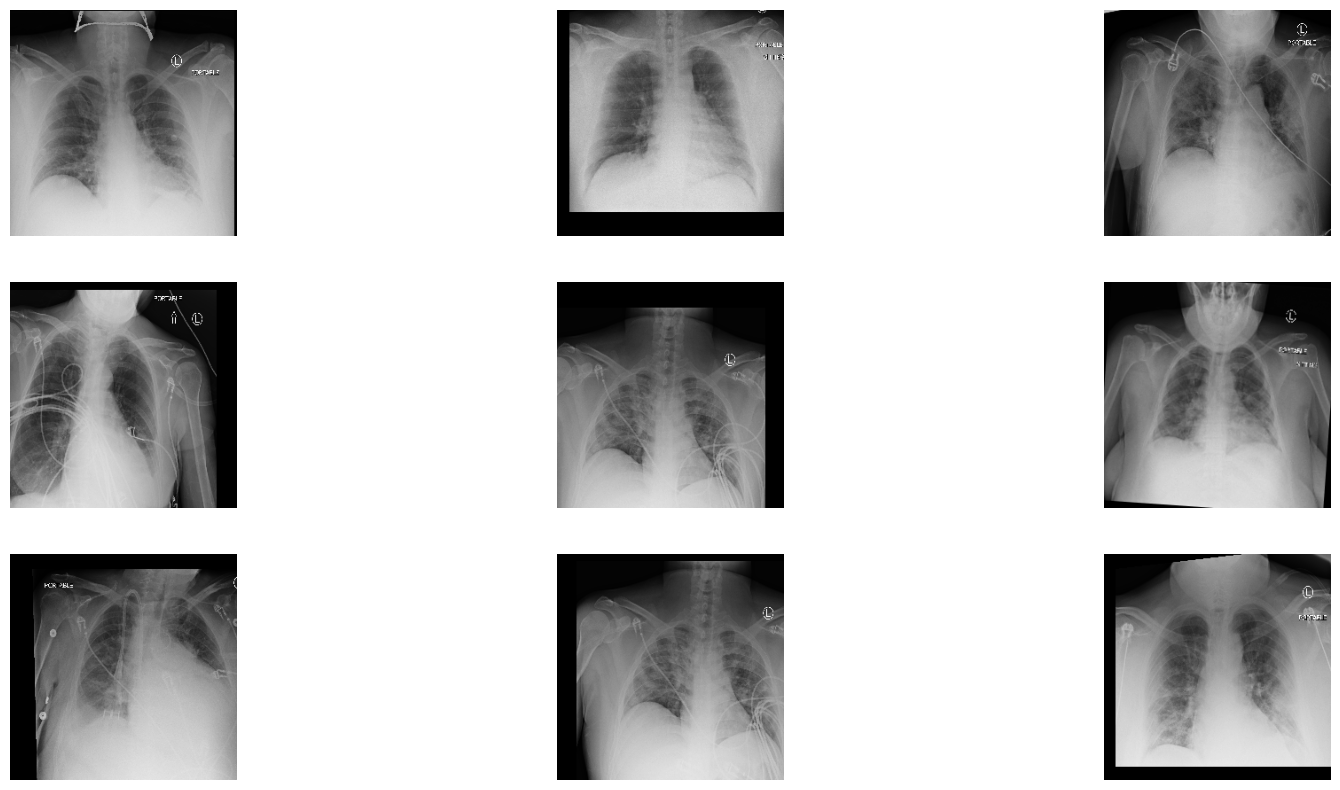

In [13]:
# Extract 9 random images
print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

for i in range(9):
    num = random.randint(0,len(n_img)-1)
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(n_img[num], cv2.COLOR_BGR2GRAY),cmap='gray')
   
    plt.axis('off')
    
    
# Adjust subplot parameters to give specified padding
plt.show()
# plt.tight_layout()

## Training data cross validation + imbalance (data augmentation) + training 

In [14]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
# training validation k fold split
fold_no = 1
acc_per_fold = []
loss_per_fold = []
# reinitialize(model)
start_time = time.time()

for train, val in kfold.split(x_train, y_train):
    
    #  Data augmentation for training data
    n_img,n_label = oversample_images(x_train[train], y_train[train], img_size)
    x_training = np.append(x_train[train],n_img,axis=0)
    y_training = np.append(y_train[train],n_label)
#     print('x_train',x_training.shape)
#     print('y_train',y_training.shape)
#     print("True: ", y_training.sum())
#     print("False: ",len(y_training) - y_training.sum())

    # Data augmentation for validation data
    n_img,n_label = oversample_images(x_train[val], y_train[val], img_size)
    x_val = np.append(x_train[val],n_img,axis=0)
    y_val = np.append(y_train[val],n_label)
#     print('x_val',x_val.shape)
#     print('y_val',y_val.shape)
#     print("True: ", y_val.sum())
#     print("False: ",len(y_val) - y_val.sum())


    opt = tf.keras.optimizers.Adam(learning_rate=0.02)
    model_lr_reducing = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto', min_lr=1e-8)
    model.compile(optimizer=opt, loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
    # history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=30, validation_split=0.2, callbacks=[model_lr_reducing] )
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(x=x_training, y=y_training, batch_size=32, epochs=20, validation_data=(x_val, y_val), callbacks=[model_lr_reducing] )
    
    scores = model.evaluate(x_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no = fold_no + 1
    
    
print('Average k-fold accuarcy:',np.mean(acc_per_fold))
print("--- %s seconds ---" % (time.time() - start_time))

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
44/44 [==============================] - 11s 146ms/step - loss: 0.6887 - accuracy: 0.6151 - val_loss: 5326.4756 - val_accuracy: 0.4917
Epoch 2/20
44/44 [==============================] - 5s 105ms/step - loss: 0.5045 - accuracy: 0.7747 - val_loss: 142.5875 - val_accuracy: 0.5028
Epoch 3/20
44/44 [==============================] - 5s 105ms/step - loss: 0.4919 - accuracy: 0.7534 - val_loss: 47.6941 - val_accuracy: 0.5056
Epoch 4/20
44/44 [==============================] - 5s 105ms/step - loss: 0.4549 - accuracy: 0.7853 - val_loss: 26.5029 - val_accuracy: 0.4972
Epoch 5/20
44/44 [==============================] - 5s 105ms/step - loss: 0.4048 - accuracy: 0.8051 - val_loss: 3.3679 - val_accuracy: 0.5528
Epoch 6/20
44/44 [==============================] - 5s 105ms/step - loss: 0.3865 - accuracy: 0.8279 - val_loss: 4.0130 - val_accuracy: 0.5611
Epoch 7/20
44/44 [=========================

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(x_test)
print(y_pred)
# compute confusion matrix with `tf` 
confusion = tf.math.confusion_matrix(
              labels = y_test,      # get trule labels 
              predictions = y_pred>0.5,  # get predicted labels 
              num_classes=2)              # no. of classifier 

print(confusion)
acc = float((confusion[0,0]+confusion[1,1])/(confusion[0,0]+confusion[0,1]+confusion[1,0]+confusion[1,1]))
acc

In [12]:
model.save('saved_model/covid_resnet50.h5')